In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from pyomo.environ import *
from optimization_utils import *
from data_processing_utils import get_ramps_per_segment, get_lanes_per_segment
from param_loader import METANET_Params
from simulation_utils import *

In [6]:
# CALIBRATE SYNTHETIC SCENARIO
rho_hat = np.load("synthetic-scenario/p_synthetic.npy")
q_hat = np.load("synthetic-scenario/q_synthetic.npy")
data_inflow = np.load("synthetic-scenario/inflow_synthetic.npy")
downstream_density = np.load("synthetic-scenario/downstream_density_synthetic.npy")

print("rho_hat shape:", rho_hat.shape)
print("q_hat shape:", q_hat.shape)

T = 10 / 3600
l = 0.4
num_calibrated_segments = 15
include_ramping = False
varylanes = False

boundary_conditions = {
    "initial_flow": data_inflow,
    "downstream_density": downstream_density,
}

results = run_calibration(
    rho_hat,
    q_hat,
    T,
    l,
    num_calibrated_segments=num_calibrated_segments,
    sep_boundary_conditions=boundary_conditions,
    lane_mapping = [4 if i < 10 else 2 for i in range(num_calibrated_segments)],
    include_ramping=include_ramping,
    smoothing=False,
    # constraint_tol=1e-8,
)

rho_hat shape: (361, 15)
q_hat shape: (361, 15)
0 15
361 15
(361, 1)
(361, 1)
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2]
Ipopt 3.14.19: max_iter=20000
acceptable_constr_viol_tol=1e-12
constr_viol_tol=1e-12


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    84990
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    84840

Total number of variables............................:    16335
                     variables with only lower bounds:        0
          

KeyboardInterrupt: 

In [5]:
# Save initial and downstream conditions
import os
RESULTS_DIR = "synthetic-calibration-results"
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
np.save(f"{RESULTS_DIR}/upstream_flow.npy", q_hat[:, 0])
np.save(f"{RESULTS_DIR}/downstream_density.npy", rho_hat[:, -1])

tau_array = results["tau"]
K_array = results["K"]
eta_high_array = results["eta_high"]
rho_crit_array = results["rho_crit"]
v_free_array = results["v_free"]
a_array = results["a"]
num_lanes_array = results["num_lanes"]
# if include_ramping:
    # gamma_array = results["gamma"]
beta_array = results["beta"]
r_inflow_array = results["r_inflow"]


# Save everything
v_pred_array = results["v_pred"]
rho_pred_array = results["rho_pred"]
q_array = v_pred_array * rho_pred_array
np.save(f"{RESULTS_DIR}/tau.npy", tau_array)
np.save(f"{RESULTS_DIR}/K.npy", K_array)
np.save(f"{RESULTS_DIR}/eta_high.npy", eta_high_array)
np.save(f"{RESULTS_DIR}/rho_crit.npy", rho_crit_array)
np.save(f"{RESULTS_DIR}/v_free.npy", v_free_array)
np.save(f"{RESULTS_DIR}/a.npy", a_array)
np.save(f"{RESULTS_DIR}/num_lanes.npy", num_lanes_array)
np.save(f"{RESULTS_DIR}/q_pred.npy", q_array)
np.save(f"{RESULTS_DIR}/v_pred.npy", v_pred_array)
np.save(f"{RESULTS_DIR}/rho_pred.npy", rho_pred_array)
# np.save("r_array.npy", r_array)
# if include_ramping:
    # np.save("gamma_array.npy", gamma_array)
np.save(f"{RESULTS_DIR}/beta_array.npy", beta_array)
np.save(f"{RESULTS_DIR}/r_inflow_array.npy", r_inflow_array)



NameError: name 'results' is not defined

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def perturb_and_plot_mape(base_params, rho_hat, q_hat, v_hat, num_lanes_array):
    params = base_params.get_params()
    results = {}
    step = 0.001
    perturb_range = np.arange(-0.1, 0.1 + step, step)


    for key, values in params.items():
        # Only perturb calibrated parameters
        if key not in ['eta_high', 'K', 'tau', 'p_crit', 'v_free', 'a']:
            continue

        values = np.array(values, dtype=float)
        mape_list = []

        print(f"\n=== Perturbing {key} ===")

        # Loop over perturbation levels
        for pct in perturb_range:
            perturbed_params = {k: np.array(v, dtype=float).copy() for k, v in params.items()}

            # Perturb each segment proportionally to its own mean value
            perturbed_params[key] = values * (1 + pct)

            v_sim = metanet_sim_fn(perturbed_params, rho_hat, q_hat, num_lanes_array)

            # Compute MAPE between simulated and observed velocities
            mape_res = mape(v_hat[:, 1:-1], v_sim[:-1, :])
            mape_list.append(mape_res)

        results[key] = np.array(mape_list)

        plt.figure(figsize=(6, 4))
        plt.plot(perturb_range * 100, results[key], linewidth=2)  # no marker
        plt.title(f"Effect of ±10% perturbation on {key}")
        plt.xlabel("Perturbation (%)")
        plt.ylabel("MAPE (%)")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.axvline(0, color='black', linestyle=':', linewidth=1)  # optional: vertical line at 0%
        plt.tight_layout()
        
        plt.savefig(f"perturb-results/{key}_perturb.png")
        plt.show()

    return results



def metanet_sim_fn(perturbed_params, rho_hat, q_hat, num_lanes_array):

    scaled_rho_hat = rho_hat[:, 1:-1] / np.array(num_lanes_array)


    downstream_density = smooth_inflow(rho_hat[:, -1]) / num_lanes_array[-1]
    data_inflow = smooth_inflow(q_hat[:, 0])
    
    init_traffic_state = (scaled_rho_hat[0, :], v_hat[0, 1:-1], data_inflow[0], 0)
    rho_sim, v_sim, _, _ = run_metanet_sim(
        T=T,
        l=l,
        init_traffic_state=init_traffic_state,
        demand=data_inflow,
        downstream_density=downstream_density,
        params=perturbed_params,
        vsl_speeds=None,
        lanes={i: num_lanes_array[i] for i in range(num_calibrated_segments)},
        plotting=True,
        real_data=True,
    )
    return v_sim


In [3]:
# Load parameter files
num_calibrated_segments = 14
RESULTS_DIR = "calibration_results"
params = METANET_Params(path=RESULTS_DIR, num_segments=num_calibrated_segments)
rho_hat = np.load("data/density_10sec_400m_1hr.npy")
q_hat = np.load("data/flow_10sec_400m_1hr.npy")
v_hat = np.load("data/velocity_10sec_400m_1hr.npy")
num_lanes_array = np.load(RESULTS_DIR + "/num_lanes.npy")

T = 10 / 3600
l = 0.4

In [4]:
print("Simulating with calibrated parameters...")

# Scale densities per lane for simulation
scaled_rho_hat = rho_hat[:, 1:-1] / np.array(num_lanes_array)


# if smoothing boundary conditions
downstream_density = smooth_inflow(rho_hat[:, -1]) / num_lanes_array[-1]
data_inflow = smooth_inflow(q_hat[:, 0])

# Sim requires tuple of initial conditions: density, velocity, inflow, and queue
init_traffic_state = (scaled_rho_hat[0, :], v_hat[0, 1:-1], data_inflow[0], 0)

rho_sim, v_sim, _, tts_sim = run_metanet_sim(
    T, 
    l, 
    init_traffic_state,
    data_inflow,
    downstream_density,
    params,
    vsl_speeds=None,
    lanes={i: num_lanes_array[i] for i in range(num_calibrated_segments)},
    plotting=True,
    real_data=True
)

In [5]:
# # error
# print(v_sim.shape)
# v_plot_true = v_hat[:, 1:-1]

# print(mape(v_plot_true, v_sim[:-1,:]))

In [6]:


# fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)



# # --- Simulation ---
# im1 = axes[0].imshow(
#     v_sim.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
# )
# axes[0].set_xlabel("Time Step")
# axes[0].set_title("Simulation Velocity (v)")
# fig.colorbar(im1, ax=axes[0], label="Velocity")


# # --- Ground Truth ---
# im2 = axes[1].imshow(
#     v_plot_true.T, aspect="auto", origin="lower", cmap="RdYlGn", interpolation="none"
# )
# axes[1].set_xlabel("Time Step")
# axes[1].set_title("Ground Truth Velocity (v)")
# fig.colorbar(im2, ax=axes[1], label="Velocity")

# plt.tight_layout()
# plt.show()


=== Perturbing tau ===


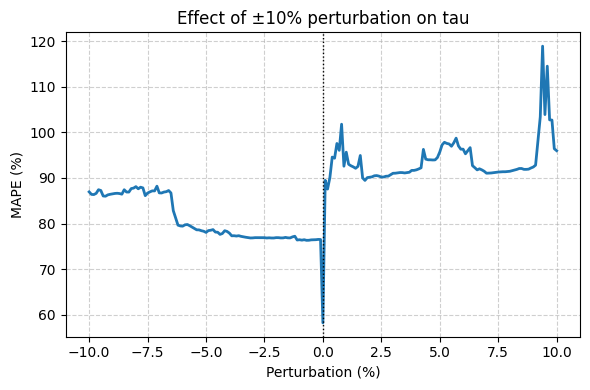


=== Perturbing K ===


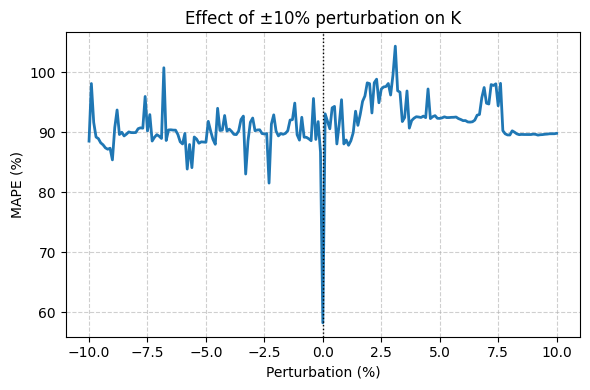


=== Perturbing eta_high ===


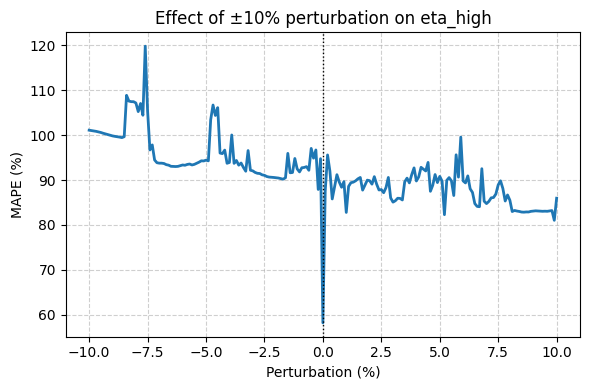


=== Perturbing p_crit ===


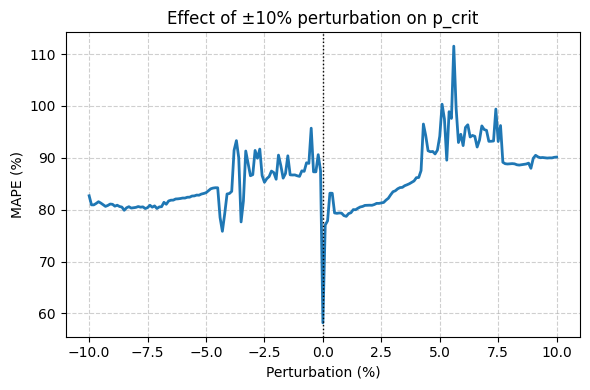


=== Perturbing v_free ===


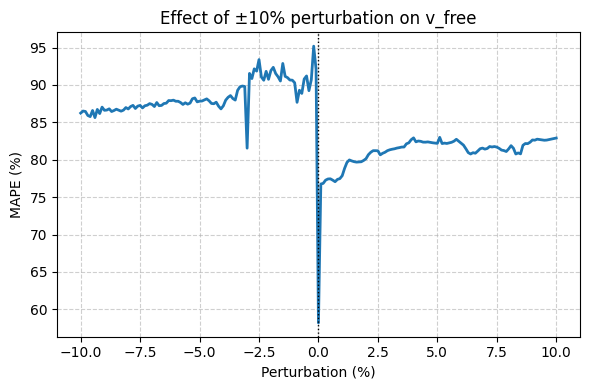


=== Perturbing a ===


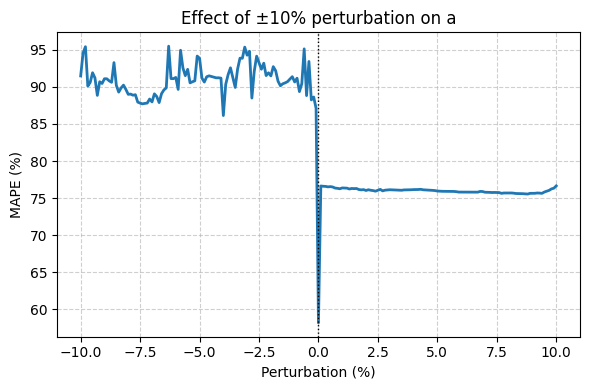

In [61]:
mape_results = perturb_and_plot_mape(params, rho_hat, q_hat, v_hat, num_lanes_array)